In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from google.colab import drive
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import warnings
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

Mounted at /content/drive


Cần lấy được AUC của từng cái
Lấy nhãn dự đoán + nhãn

In [2]:
def process_time_column(path):
    df = pd.read_csv(path).drop_duplicates().drop(columns=['Name', 'id'])
    df['utc_time'] = pd.to_datetime(df['utc_time'])
    df['day'], df['month'] = pd.Series(np.array(df['utc_time'].dt.day)), pd.Series(np.array(df['utc_time'].dt.month))
    return df.drop(columns=['utc_time'])

In [3]:
def get_data(num_case):
    df_tr = process_time_column('/content/drive/My Drive/Data_match (new)/cv' + str(num_case) + '_data_train_92022.csv')
    df_tst = process_time_column('/content/drive/My Drive/Data_match (new)/cv' + str(num_case) + '_data_test_92022.csv')
    return np.array(df_tr.drop(columns=['value'])), np.array(df_tr['value']), np.array(df_tst.drop(columns=['value'])), np.array(df_tst['value'])

In [4]:
def get_result(num_case):
    X_train, y_train, X_test, y_regr_true = get_data(num_case)

    rfc = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=8, criterion='gini', random_state=42)
    rfr = RandomForestRegressor(n_estimators=500, max_features='sqrt', max_depth=8, criterion='squared_error', random_state=42)
    '''
    param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [7,8],
    'criterion' :['gini', 'entropy'],
    'random_state':[42]
    }
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_cls_true)
    rfc = RandomForestClassifier(CV_rfc.best_params_)
    '''
    y_cls_train = (y_train > 0).astype(np.int16)
    rfc.fit(X_train, y_cls_train)
    y_cls_pred = rfc.predict_proba(X_test)[:, 1]
    y_cls_true = (y_regr_true > 0).astype(np.int16)
    a = rfc.predict(X_train)

    '''
    param_grid = { 
    'n_estimators': [500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [7,8],
    'criterion' :['squared_error', 'absolute_error', 'poisson'],
    'random_state':[42]
    }
    '''
    rX_train = np.array([X_train[i] for i in range(X_train.shape[0]) if a[i] == 1])
    ry_train = np.array([y_train[i] for i in range(X_train.shape[0]) if a[i] == 1])
    '''
    CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
    CV_rfr.fit(rX_train, ry_train)
    rfr = RandomForestRegressor(CV_rfr.best_params_)
    '''
    rfr.fit(rX_train, ry_train)
    y_pred = rfc.predict(X_test)
    y_regr_pred = rfr.predict(X_test)
    y_regr_pred = np.array([y_pred[i] * y_regr_pred[i] for i in range(y_regr_pred.shape[0])])

    return y_cls_pred, y_cls_true, y_regr_pred, y_regr_true

---

In [23]:
y_cls_pred, y_cls_true, y_regr_pred, y_regr_true = get_result(13)

In [24]:
print(classification_report((y_cls_pred > 0.5).astype(np.int16), y_cls_true))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71     33835
           1       0.35      0.53      0.43     12247

    accuracy                           0.62     46082
   macro avg       0.57      0.59      0.57     46082
weighted avg       0.68      0.62      0.64     46082



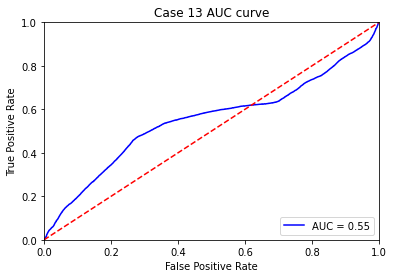

In [25]:
fpr, tpr, threshold = roc_curve((y_cls_true > 0).astype(np.int16), y_cls_pred)
roc_auc = auc(fpr, tpr)
plt.title('Case 13 AUC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5, 1.0, 'Case 13 CM')

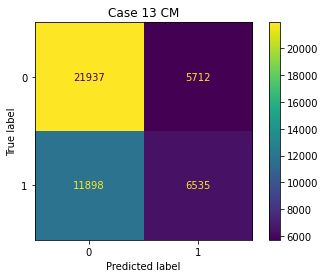

In [26]:
cfmd = ConfusionMatrixDisplay(confusion_matrix(y_cls_true, (y_cls_pred > 0.5).astype(np.int16)))
cfmd.plot()
cfmd.ax_.set_title("Case 13 CM")

In [27]:
print('Case 13 MSE: %.2f' % mean_squared_error(y_regr_true, y_regr_pred))

Case 13 MSE: 7.93


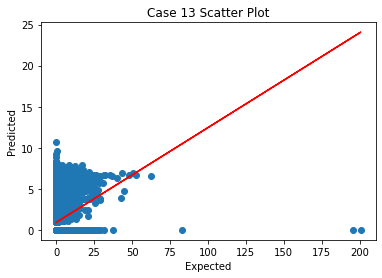

In [28]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Case 13 Scatter Plot')
plt.plot(y_regr_true, y_regr_pred, 'o')
m, b = np.polyfit(y_regr_true, y_regr_pred, 1)
plt.plot(y_regr_true, m*y_regr_true + b, 'r')
plt.show()

---